In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk

from collections import Counter
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("../rawdata/hololivecomments.csv")
del df['subreddit.1']

In [3]:
df = df.dropna(axis=0, how="any", subset=None, inplace=False)

In [4]:
# Sort data berdasarkan waktu posting dan mengubah epoch value menjadi datetime UTC+7

df.sort_values(by = ["created_utc"], inplace = True, ascending = True)
df['created_utc'] = pd.DatetimeIndex(pd.to_datetime(df['created_utc'], unit='s')).tz_localize('UTC').tz_convert('Asia/Jakarta')

In [5]:
display(df.head(5))
display(df.tail(5))
display(df.info())

,subreddit,id,submission_id,created_utc,author,score,body,parent_id,permalink
406059,Hololive,ff4gful,erj4fp,2020-01-21 06:30:06+07:00,raystrife96,4.0,"I'm not up-to-date with Rushia, but I think th...",t3_erj4fp,/r/Hololive/comments/erj4fp/i_have_some_questi...
406061,Hololive,ff6nd9s,erj4fp,2020-01-22 01:21:24+07:00,raystrife96,2.0,"Yeah, if she changes to her default outfit, th...",t1_ff5k2n9,/r/Hololive/comments/erj4fp/i_have_some_questi...
406050,Hololive,ffhj7ub,etl9ue,2020-01-25 14:35:10+07:00,raystrife96,16.0,Okayu and Korone form a great pair too for cut...,t3_etl9ue,/r/Hololive/comments/etl9ue/what_pair_do_you_t...
406052,Hololive,ffhy6m7,etl9ue,2020-01-25 20:29:34+07:00,JustAnotherPep,3.0,"I haven't watched any of their stuff yet, I gu...",t1_ffhj7ub,/r/Hololive/comments/etl9ue/what_pair_do_you_t...
406051,Hololive,ffi49xe,etl9ue,2020-01-25 22:04:17+07:00,GuiMr27,3.0,Hmmmmmm... maybe FAMS? Idk,t3_etl9ue,/r/Hololive/comments/etl9ue/what_pair_do_you_t...


,subreddit,id,submission_id,created_utc,author,score,body,parent_id,permalink
2380082,Hololive,jadiweg,zd2bh2,2023-03-01 00:38:42+07:00,Chrisjared96,1.0,In the words of Mike Tyson which is very much ...,t1_iz3yflk,/r/Hololive/comments/zd2bh2/joint_statement/ja...
323369,Hololive,jafc2nw,i1078g,2023-03-01 07:52:04+07:00,DragonfruitAsleep976,1.0,Time scam every round: Warukunai yo ne\~,t3_i1078g,/r/Hololive/comments/i1078g/watame_is_in_granb...
478475,Hololive,jaffib4,klrhbh,2023-03-01 08:18:08+07:00,Electric-Guitar-9022,1.0,I think it because does the cartoon character ...,t3_klrhbh,/r/Hololive/comments/klrhbh/why_do_some_people...
406047,Hololive,jajp76x,ewewcp,2023-03-02 05:31:02+07:00,Erotically-Yours,1.0,"So I'm extremely late, and expect no response ...",t3_ewewcp,/r/Hololive/comments/ewewcp/i_love_haato_akais...
406048,Hololive,jand911,ewewcp,2023-03-03 00:50:44+07:00,Wackydude1234,1.0,I'm not sure if there is I've not been followi...,t1_jajp76x,/r/Hololive/comments/ewewcp/i_love_haato_akais...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2285265 entries, 406059 to 406048
Data columns (total 9 columns):
 #   Column         Dtype                       
---  ------         -----                       
 0   subreddit      object                      
 1   id             object                      
 2   submission_id  object                      
 3   created_utc    datetime64[ns, Asia/Jakarta]
 4   author         object                      
 5   score          float64                     
 6   body           object                      
 7   parent_id      object                      
 8   permalink      object                      
dtypes: datetime64[ns, Asia/Jakarta](1), float64(1), object(7)
memory usage: 174.4+ MB


None

In [11]:
nltk.download('punkt')
nltk.download('stopwords')

STOP_WORDS = stopwords.words()

# removing the emojies
# https://www.kaggle.com/alankritamishra/covid-19-tweet-sentiment-analysis#Sentiment-analysis
EMOJI_PATTERN = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)


def cleaning(text):
    """
    Convert to lowercase.
    Rremove URL links, special characters and punctuation.
    Tokenize and remove stop words.
    """
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)

    text = EMOJI_PATTERN.sub(r'', text)

    # removing the stop-words
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in STOP_WORDS]
    filtered_sentence = (" ").join(tokens_without_sw)
    text = filtered_sentence

    return text

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df2 = df.copy()

df2['body'] = df2['body'].apply(cleaning)
df2.to_csv("../rawdata/hololivecomments_cleaned.csv", index=False)

Regression Formula: y = 312.7929x + 4092.5519


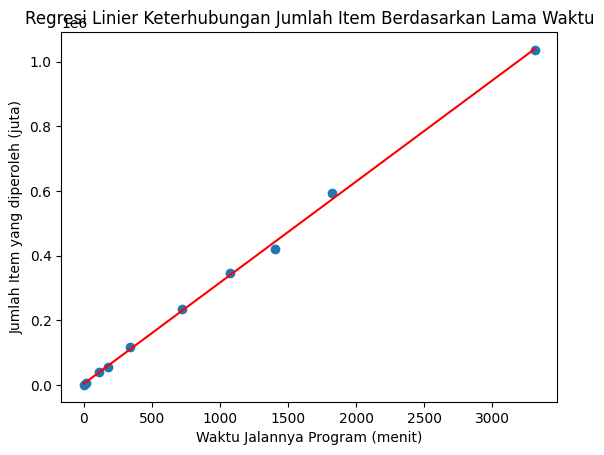

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Define the x and y data
x = np.array([0.1, 18.3, 109.4, 175.6, 340.6, 722.8, 1075.2, 1407.4, 1824.7, 3310.8])
y = np.array([157, 5957, 40486, 54697, 117885, 236340, 345979, 421088, 592810, 1035939])

# Reshape the x data to fit the format expected by scikit-learn
x = x.reshape(-1, 1)

# Create and fit the linear regression model
model = LinearRegression().fit(x, y)

# Print the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_
print(f"Regression Formula: y = {slope:.4f}x + {intercept:.4f}")

# Create a scatter plot of the data
plt.scatter(x, y)

# Add the regression line to the plot
plt.plot(x, model.predict(x), color='red')

# Add labels and legend to the plot
plt.xlabel('Waktu Jalannya Program (menit)')
plt.ylabel('Jumlah Item yang diperoleh (juta)')
plt.title('Regresi Linier Keterhubungan Jumlah Item Berdasarkan Lama Waktu')

# Show the plot
plt.show()


Regression Formula (Total): y = 0.0026x + 0.0502
Regression Formula (JSON): y = 0.0023x + -0.0414
Regression Formula (CSV): y = 0.0002x + 0.0916


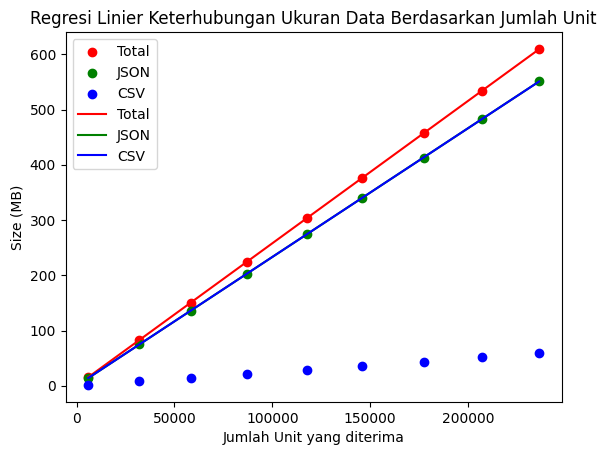

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Define the first set of x and y data
x1 = np.array([5956, 32128, 58256, 86960, 117877, 146100, 177287, 207165, 236340])
y1 = np.array([15.4, 83.4, 150.2, 223.8, 303.6, 376.6, 456.8, 533.9, 609.7])

# Define the second set of x and y data
x2 = np.array([5956, 32128, 58256, 86960, 117877, 146100, 177287, 207165, 236340])
y2 = np.array([13.9, 75.2, 135.8, 202.3, 274.4, 340.4, 413, 482.7, 551.2])

# Define the third set of x and y data
x3 = np.array([5956, 32128, 58256, 86960, 117877, 146100, 177287, 207165, 236340])
y3 = np.array([1.5, 8.2, 14.4, 21.5, 29.2, 36.2, 43.8, 51.2, 58.5])

# Reshape the x data to fit the format expected by scikit-learn
x1 = x1.reshape(-1, 1)
x2 = x2.reshape(-1, 1)
x3 = x3.reshape(-1, 1)

# Create and fit the linear regression model for the first set of data
model1 = LinearRegression().fit(x1, y1)

# Print the slope and intercept of the regression line for the first set of data
slope1 = model1.coef_[0]
intercept1 = model1.intercept_
print(f"Regression Formula (Total): y = {slope1:.4f}x + {intercept1:.4f}")

# Create and fit the linear regression model for the second set of data
model2 = LinearRegression().fit(x2, y2)

# Print the slope and intercept of the regression line for the second set of data
slope2 = model2.coef_[0]
intercept2 = model2.intercept_
print(f"Regression Formula (JSON): y = {slope2:.4f}x + {intercept2:.4f}")

# Create and fit the linear regression model for the third set of data
model3 = LinearRegression().fit(x3, y3)

# Print the slope and intercept of the regression line for the third set of data
slope3 = model3.coef_[0]
intercept3 = model3.intercept_
print(f"Regression Formula (CSV): y = {slope3:.4f}x + {intercept3:.4f}")

# Create a scatter plot of both datasets
plt.scatter(x1, y1, color="red", label="Total")
plt.scatter(x2, y2, color="green", label="JSON")
plt.scatter(x3, y3, color="blue", label="CSV")

# Add the regression lines to the plot
plt.plot(x1, model1.predict(x1), color="red", label="Total")
plt.plot(x2, model2.predict(x2), color="green", label="JSON")
plt.plot(x3, model2.predict(x3), color="blue", label="CSV")

# Add labels and legend to the plot
plt.xlabel('Jumlah Unit yang diterima')
plt.ylabel('Size (MB)')
plt.title('Regresi Linier Keterhubungan Ukuran Data Berdasarkan Jumlah Unit')
plt.legend()

# Show the plot
plt.show()


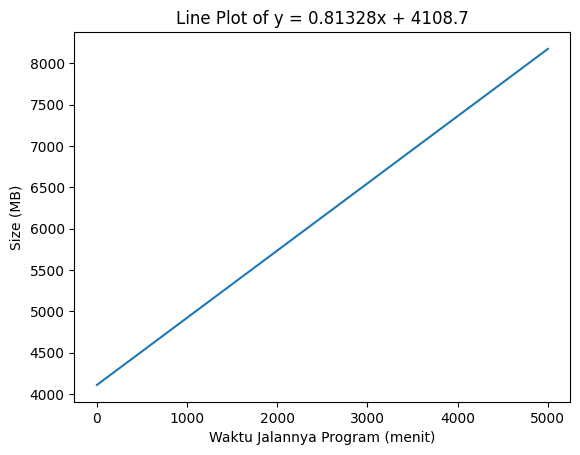

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Define the x values to plot
x = np.linspace(0, 5000, 1000)

# Define the equation of the line
y = 0.81328*x + 4108.7

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the line
ax.plot(x, y)

# Set the axis labels and title
ax.set_xlabel('Waktu Jalannya Program (menit)')
ax.set_ylabel('Size (MB)')
ax.set_title('Line Plot of y = 0.81328x + 4108.7')

# Show the plot
plt.show()
